In [4]:
import json
import datetime
import pandas as pd
import pprint
import warnings
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [7]:
class changelog_parser:
    def __init__(self, gdoc_data):
        self.doc = None
        self.logs = []
        
        with open(gdoc_data,'r') as f:
            for line in f.readlines()[1:]:
                self.changelog = json.loads(line)['changelog']
    
    def log_entry(self, log):
        return {
            'changes': None,
            'time': log[1],
            'user_id': log[2],
            'index': log[3],
            'bigstring': log[4],
            'unknown_index': log[5],
            'unknown_item': log[6],
            'log_type': log[0]['ty']
        }
     
    def parse(self):
        for log in self.changelog:
            datum = self.log_entry(log) 
            changes = self._extract(log[0])
            if changes:
                datum['changes'] = changes
                            
            self.logs.append(datum)
        
    def _extract(self, log):
        '''
        To be written. 
        '''
        try:
            extract = getattr(changelog_parser, '_extract_' + log['ty'])
            changes = extract(self, log)
            return changes
        except:
#             print "Did not work: %s" % log['ty']
#             print log
            return None
            
    def _extract_is(self, log):
        '''
        is =? insert str
        '''
        return log['s']
    
    def _extract_ds(self, log):
        '''
        ds =? delete str
        '''
        return log
    
    def _extract_mlti(self, log):
        '''
        mlti =? multiple type interactions
        '''
        mltichanges = []
        for sublog in log['mts']:
            mltichanges.append(self._extract(sublog))

        mltichanges = [x for x in mltichanges if x is not None]
            
        return mltichanges
            


In [61]:
# cp = changelog_parser('/Users/das1192/Downloads/json (11).txt')
# cp.parse()
# col_order = ['time','user_id','log_type','changes']
# data = pd.DataFrame(cp.logs)#[col_order]  
# data.ix[:,'time'] =  data.time.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

# # print data
# print len(data)

data = []
for gdoc in ['/Users/das1192/Downloads/json (11).txt']+glob('doc-revisions/data/*.txt')[0:1]:#glob('doc-revisions/data/*.txt')[0:1]:
    cp = changelog_parser(gdoc)
    cp.parse()
    tmp = pd.DataFrame(cp.logs)
    tmp['doc_id'] = gdoc
    data.append(tmp)

data = pd.concat(data, axis=0)
data = data.rename(columns={'unknown_index':'document_index'})
data.ix[:,'time'] =  data.time.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

data.count()
data.groupby('doc_id').head()

,bigstring,changes,index,log_type,time,document_index,unknown_item,user_id,doc_id
0,None,None,1,rplc,2016-03-11 07:24:03.858,NaN,None,07412325945122838097,/Users/das1192/Downloads/json (11).txt
1,2a568352f7f92dab,[\n],2,mlti,2016-03-11 07:30:55.763,0,None,07412325945122838097,/Users/das1192/Downloads/json (11).txt
2,2a568352f7f92dab,[Overview\nThe goal of this project is to iden...,3,mlti,2016-03-11 07:30:56.377,1,None,07412325945122838097,/Users/das1192/Downloads/json (11).txt
3,2a568352f7f92dab,"[[\n], [\n]]",4,mlti,2016-03-11 07:30:58.040,2,None,07412325945122838097,/Users/das1192/Downloads/json (11).txt
4,2a568352f7f92dab,"[{u'si': 40, u'ei': 127, u'ty': u'ds'}, e ]",5,mlti,2016-03-11 07:31:00.882,3,None,07412325945122838097,/Users/das1192/Downloads/json (11).txt
0,None,None,1,mlti,2016-03-05 15:24:14.271,NaN,None,15537773617043190792,doc-revisions/data/1Fg6PEkluhNSRJeXunZ7jZS0E1i...
1,6abf4aebe5be1773,None,2,null,2016-03-05 15:24:24.671,0,None,15537773617043190792,doc-revisions/data/1Fg6PEkluhNSRJeXunZ7jZS0E1i...
2,6abf4aebe5be1773,I.,3,is,2016-03-05 15:24:30.140,1,None,15537773617043190792,doc-revisions/data/1Fg6PEkluhNSRJeXunZ7jZS0E1i...
3,6abf4aebe5be1773,"[{u'si': 1, u'ei': 2, u'ty': u'ds'}]",4,mlti,2016-03-05 15:24:30.654,2,None,15537773617043190792,doc-revisions/data/1Fg6PEkluhNSRJeXunZ7jZS0E1i...
4,6abf4aebe5be1773,qu,5,is,2016-03-05 15:24:34.245,3,None,15537773617043190792,doc-revisions/data/1Fg6PEkluhNSRJeXunZ7jZS0E1i...


(-50, 3500.0)

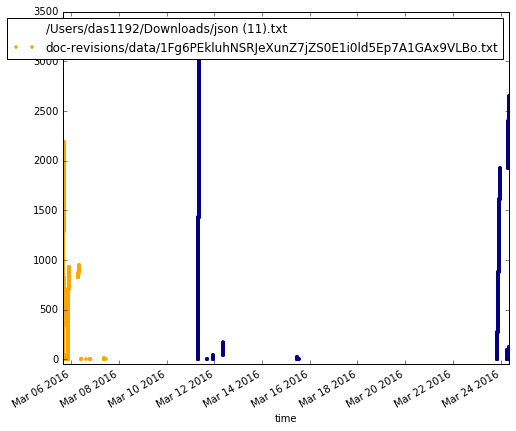

In [63]:
fig, ax1 = plt.subplots(1,1,figsize=(8,7))
ccycle = ['Navy','Orange']

grouped = data.groupby('doc_id')
ccycle = dict(zip(grouped.groups,ccycle))

for n,g in grouped:
    g.plot(x='time', y='document_index', style='.', ax=ax1, color=ccycle[n], label=n)
# ax1.set_xlim(-50,)
ax1.set_ylim(-50,)

In [26]:
pd.crosstab(data.time.apply(lambda x: str(x.date())+':'+str(x.hour)), data.user_id)

user_id,06287517911256457317,15537773617043190792
time,,
2016-03-05:15,0,1271
2016-03-05:16,494,921
2016-03-05:17,332,48
2016-03-05:20,1,710
2016-03-05:21,0,221
2016-03-06:14,0,1
2016-03-06:18,6,0
2016-03-06:7,124,0
2016-03-06:9,0,7


In [25]:
print data.changes.apply(lambda x: len(x) if x else None)

0      NaN
1      NaN
2        2
3        1
4        2
5        3
6        2
7        2
8        2
9        4
10       4
11       2
12       3
13       1
14       2
15       2
16       2
17       2
18       3
19       3
20       2
21       2
22       2
23       1
24       2
25       1
26       2
27       3
28       2
29       4
        ..
4122     3
4123     3
4124     3
4125    21
4126    11
4127     1
4128     1
4129     1
4130     2
4131     2
4132     2
4133     2
4134     4
4135     2
4136     2
4137     4
4138     2
4139     3
4140     3
4141     1
4142     1
4143     5
4144     3
4145     1
4146     1
4147     2
4148     2
4149     1
4150     1
4151     3
Name: changes, dtype: float64
